In [1]:
import os, sys, json, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
from tqdm import tqdm

In [2]:
from google.colab import files
files.upload()


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
os.listdir('/content')


['.config', 'artifacts', 'sample_data']

In [ ]:
from pathlib import Path
import json, pandas as pd

DATA_PATH = Path('/content/data.json')

with open(DATA_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(data)
print(df.shape)
df.head(3)


(5000, 8)


,idx,dataset_source,human_original_text(type1),llm_generated_text(type2),human_paraphrased_text(type3),llm_paraphrased_original_text(type4)-prompt-based,llm_paraphrased_generated_text(type5)-1st,llm_paraphrased_generated_text(type5)-3rd
0,0,mrpc,"Amrozi accused his brother , whom he called "" ...",Amrozi accused his brother of being an accompl...,"Referring to him as only "" the witness "" , Amr...","Amrozi charged his brother, ""the witness,"" wit...",Amrozi claimed his brother participated in the...,Amrozi claimed his brother participated in the...
1,1,mrpc,They had published an advertisement on the Int...,They had published an advertisement on the int...,"On June 10 , the ship 's owners had published ...",He noted they had advertised the cargo for sal...,They had publicized the upcoming June cargo sa...,The company publicized its planned June shippi...
2,2,mrpc,"The stock rose $ 2.11 , or about 11 percent , ...","The stock rose $ 2.50, or 3 percent, on Friday...",PG & E Corp. shares jumped $ 1.63 or 8 percent...,"Shares gained $2.11 (about 11%), concluding Fr...","On Friday, the stock's value increased by $2.5...","On Friday, the stock's price rose $2.50 (3%), ..."


In [ ]:
print('Columns:', list(df.columns))
print('\nDTypes:')
print(df.dtypes)

print('\nNull counts:')
print(df.isna().sum().sort_values(ascending=False))

# Exact duplicate rows
dup_rows = df.duplicated().sum()
print(f'\nDuplicate rows: {dup_rows}')

# Potential duplicate texts (source or paraphrase)
source_cols = [c for c in df.columns if 'human_original_text' in c.lower() or 'llm_generated' in c.lower()]
para_cols = [c for c in df.columns if 'paraphrased' in c.lower() or 'llm_paraphrased' in c.lower()]
print('Source-like columns:', source_cols)
print('Paraphrase-like columns:', para_cols)

def count_dupes(series):
    return series.value_counts().loc[lambda s: s>1].sum()

for col in source_cols + para_cols:
    if col in df.columns:
        print(f"Dupes in {col}:", count_dupes(df[col].dropna()))


Columns: ['idx', 'dataset_source', 'human_original_text(type1)', 'llm_generated_text(type2)', 'human_paraphrased_text(type3)', 'llm_paraphrased_original_text(type4)-prompt-based', 'llm_paraphrased_generated_text(type5)-1st', 'llm_paraphrased_generated_text(type5)-3rd']

DTypes:
idx                                                   int64
dataset_source                                       object
human_original_text(type1)                           object
llm_generated_text(type2)                            object
human_paraphrased_text(type3)                        object
llm_paraphrased_original_text(type4)-prompt-based    object
llm_paraphrased_generated_text(type5)-1st            object
llm_paraphrased_generated_text(type5)-3rd            object
dtype: object

Null counts:
idx                                                  0
dataset_source                                       0
human_original_text(type1)                           0
llm_generated_text(type2)                       

In [ ]:
import re

def simple_tokens(s):
    return re.findall(r"\w+", s.lower())

def text_len_stats(s):
    chars = len(s)
    toks = len(simple_tokens(s))
    return chars, toks

# choose canonical columns
COL_SOURCE = 'human_original_text(type1)'
COL_PARA   = 'llm_paraphrased_original_text(type4)-prompt-based'

assert COL_SOURCE in df.columns and COL_PARA in df.columns, 'Expected human (type1) and llm_paraphrased_original_text(type4)-prompt-based columns.'

df['len_src_chars'], df['len_src_tokens'] = zip(*df[COL_SOURCE].fillna('').map(text_len_stats))
df['len_para_chars'], df['len_para_tokens'] = zip(*df[COL_PARA].fillna('').map(text_len_stats))
df['len_delta_chars'] = df['len_para_chars'] - df['len_src_chars']
df['len_delta_tokens'] = df['len_para_tokens'] - df['len_src_tokens']

print(df['dataset_source'].value_counts(dropna=False))
df[['len_src_tokens','len_para_tokens','len_delta_tokens']].describe()

dataset_source
mrpc    3750
paws     870
hlpc     380
Name: count, dtype: int64


,len_src_tokens,len_para_tokens,len_delta_tokens
count,5000.000000,5000.000000,5000.0000
mean,26.033200,23.297600,-2.7356
std,41.964536,40.340834,4.6774
min,4.000000,4.000000,-129.0000
25%,16.000000,14.000000,-4.0000
50%,20.000000,17.000000,-2.0000
75%,24.000000,21.000000,-1.0000
max,444.000000,453.000000,38.0000


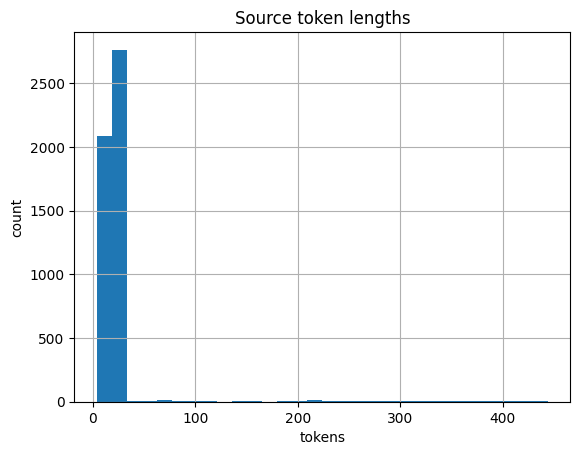

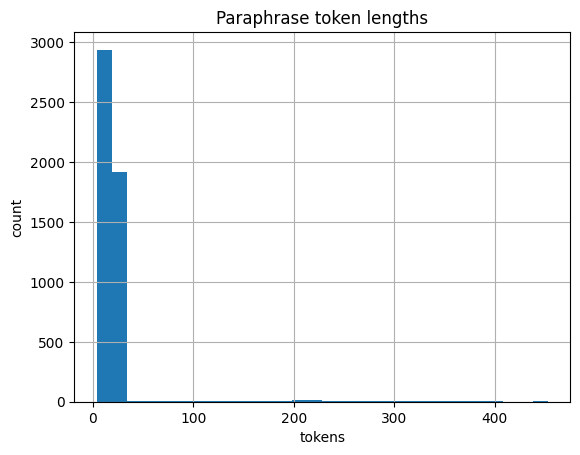

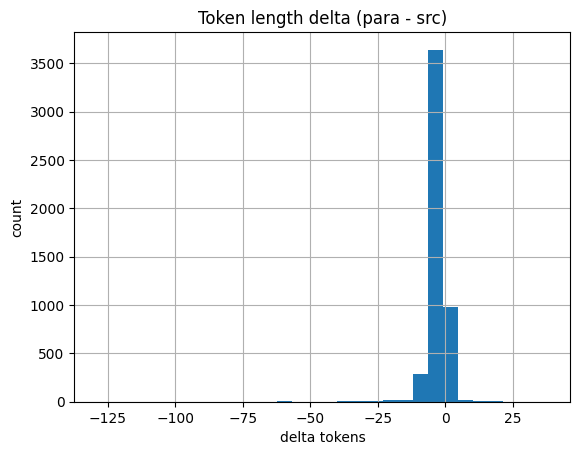

In [ ]:
# Histograms (tokens)
plt.figure()
df['len_src_tokens'].hist(bins=30)
plt.title('Source token lengths')
plt.xlabel('tokens')
plt.ylabel('count')
plt.show()

plt.figure()
df['len_para_tokens'].hist(bins=30)
plt.title('Paraphrase token lengths')
plt.xlabel('tokens')
plt.ylabel('count')
plt.show()

plt.figure()
df['len_delta_tokens'].hist(bins=30)
plt.title('Token length delta (para - src)')
plt.xlabel('delta tokens')
plt.ylabel('count')
plt.show()

In [ ]:
def jaccard(a, b):
    sa, sb = set(simple_tokens(a)), set(simple_tokens(b))
    if not sa and not sb:
        return 1.0
    return len(sa & sb) / max(1, len(sa | sb))

df['jaccard'] = [jaccard(a,b) for a,b in zip(df[COL_SOURCE].fillna(''), df[COL_PARA].fillna(''))]

df[['jaccard']].describe()

,jaccard
count,5000.000000
mean,0.448008
std,0.150156
min,0.000000
25%,0.344828
50%,0.440000
75%,0.543279
max,1.000000


In [ ]:
try:
    from Levenshtein import distance as lev_distance
    def edit_norm(a,b):
        if not a and not b:
            return 0.0
        return lev_distance(a, b) / max(1, max(len(a), len(b)))
except Exception:
    try:
        from rapidfuzz.distance import Levenshtein as RFLev
        def edit_norm(a,b):
            if not a and not b:
                return 0.0
            return RFLev.distance(a, b) / max(1, max(len(a), len(b)))
    except Exception:
        # very slow pure python fallback
        import numpy as _np
        def _lev(a,b):
            la, lb = len(a), len(b)
            dp = _np.zeros((la+1, lb+1), dtype=int)
            for i in range(la+1): dp[i,0]=i
            for j in range(lb+1): dp[0,j]=j
            for i in range(1, la+1):
                for j in range(1, lb+1):
                    cost = 0 if a[i-1]==b[j-1] else 1
                    dp[i,j] = min(dp[i-1,j]+1, dp[i,j-1]+1, dp[i-1,j-1]+cost)
            return int(dp[la,lb])
        def edit_norm(a,b):
            if not a and not b:
                return 0.0
            return _lev(a,b) / max(1, max(len(a), len(b)))


df['edit_norm'] = [edit_norm(a,b) for a,b in zip(df[COL_SOURCE].fillna(''), df[COL_PARA].fillna(''))]

df[['edit_norm']].describe()

,edit_norm
count,5000.000000
mean,0.510210
std,0.147783
min,0.086957
25%,0.405941
50%,0.505848
75%,0.612979
max,0.861702


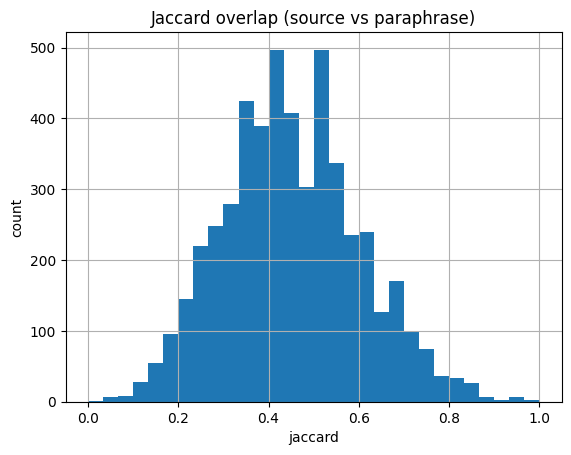

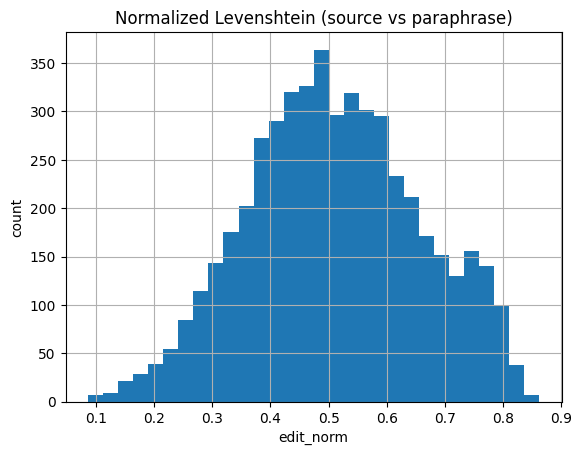

In [ ]:
# Plots
plt.figure()
df['jaccard'].hist(bins=30)
plt.title('Jaccard overlap (source vs paraphrase)')
plt.xlabel('jaccard')
plt.ylabel('count')
plt.show()

plt.figure()
df['edit_norm'].hist(bins=30)
plt.title('Normalized Levenshtein (source vs paraphrase)')
plt.xlabel('edit_norm')
plt.ylabel('count')
plt.show()

In [ ]:
def cosine(u,v):
    u = np.asarray(u); v = np.asarray(v)
    denom = (np.linalg.norm(u)*np.linalg.norm(v))
    return float(np.dot(u,v)/denom) if denom>0 else 0.0

USE_ST = True
try:
    from sentence_transformers import SentenceTransformer
    st_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
except Exception as e:
    print('sentence-transformers not available, will use TF-IDF fallback:', e)
    USE_ST = False

if USE_ST:
    texts = df[COL_SOURCE].fillna('').tolist() + df[COL_PARA].fillna('').tolist()
    embs = st_model.encode(texts, show_progress_bar=True, batch_size=64, normalize_embeddings=True)
    n = len(df)
    src_embs = embs[:n]
    para_embs = embs[n:]
    df['cosine'] = [cosine(src_embs[i], para_embs[i]) for i in range(n)]
else:
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    vect = TfidfVectorizer(min_df=2, max_df=0.9)
    X = vect.fit_transform(df[COL_SOURCE].fillna('').tolist() + df[COL_PARA].fillna('').tolist())
    n = len(df)
    src_X = X[:n]
    para_X = X[n:]
    sims = cosine_similarity(src_X, para_X)
    df['cosine'] = [sims[i,i] for i in range(n)]

df['cosine'].describe()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

,cosine
count,5000.000000
mean,0.858749
std,0.090273
min,0.357980
25%,0.812281
50%,0.878031
75%,0.925927
max,0.997687


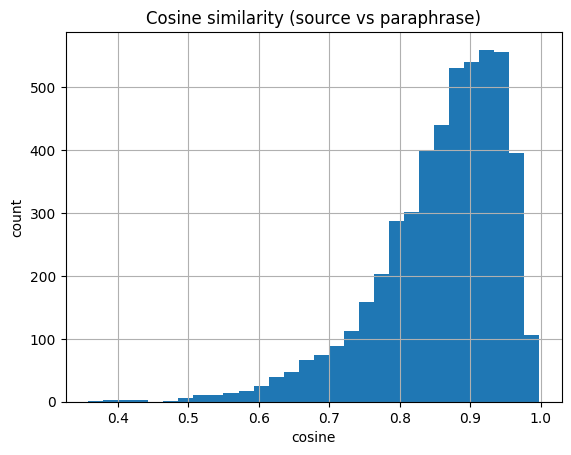

In [ ]:
plt.figure()
df['cosine'].hist(bins=30)
plt.title('Cosine similarity (source vs paraphrase)')
plt.xlabel('cosine')
plt.ylabel('count')
plt.show()

In [ ]:
DO_NLI = True  # set True to run
if DO_NLI:
    from transformers import AutoModelForSequenceClassification, AutoTokenizer
    import torch
    nli_name = 'roberta-large-mnli'
    tok = AutoTokenizer.from_pretrained(nli_name)
    mdl = AutoModelForSequenceClassification.from_pretrained(nli_name)
    mdl.eval()

    label_map = {0:'contradiction',1:'neutral',2:'entailment'}

    def nli_probs(premise, hypothesis):
        inputs = tok(premise, hypothesis, return_tensors='pt', truncation=True, max_length=256)
        with torch.no_grad():
            logits = mdl(**inputs).logits[0].softmax(-1).cpu().numpy()
        return {label_map[i]: float(logits[i]) for i in range(3)}

    sample = df.sample(min(200, len(df)), random_state=RANDOM_SEED)
    ent_src_para = []
    ent_para_src = []
    contra_max = []
    for _,row in tqdm(sample.iterrows(), total=len(sample)):
        s = row[COL_SOURCE] or ''
        p = row[COL_PARA] or ''
        sp = nli_probs(s,p)
        ps = nli_probs(p,s)
        ent_src_para.append(sp['entailment'])
        ent_para_src.append(ps['entailment'])
        contra_max.append(max(sp['contradiction'], ps['contradiction']))
    sample = sample.assign(nli_ent_src_para=ent_src_para,
                           nli_ent_para_src=ent_para_src,
                           nli_contra_max=contra_max)
    sample[['nli_ent_src_para','nli_ent_para_src','nli_contra_max']].describe()

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 200/200 [07:22<00:00,  2.21s/it]


In [ ]:
grp = df.groupby('dataset_source')[['cosine','jaccard','edit_norm','len_src_tokens','len_para_tokens']].mean()
grp

,cosine,jaccard,edit_norm,len_src_tokens,len_para_tokens
dataset_source,,,,,
hlpc,0.868763,0.412187,0.505369,100.300000,95.131579
mrpc,0.843684,0.429106,0.520586,20.268267,17.580267
paws,0.919310,0.545128,0.467599,18.443678,16.565517


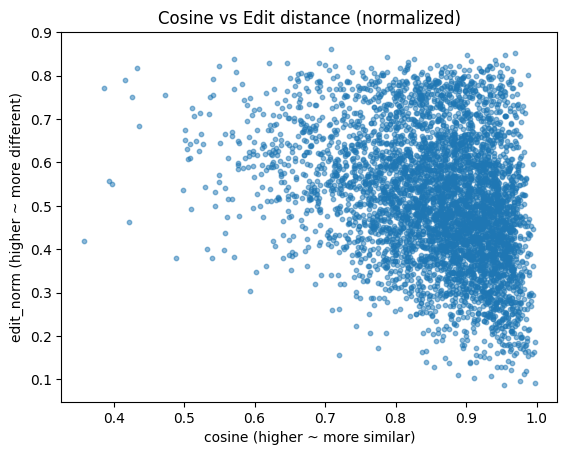

In [ ]:
plt.figure()
plt.scatter(df['cosine'], df['edit_norm'], s=10, alpha=0.5)
plt.title('Cosine vs Edit distance (normalized)')
plt.xlabel('cosine (higher ~ more similar)')
plt.ylabel('edit_norm (higher ~ more different)')
plt.show()

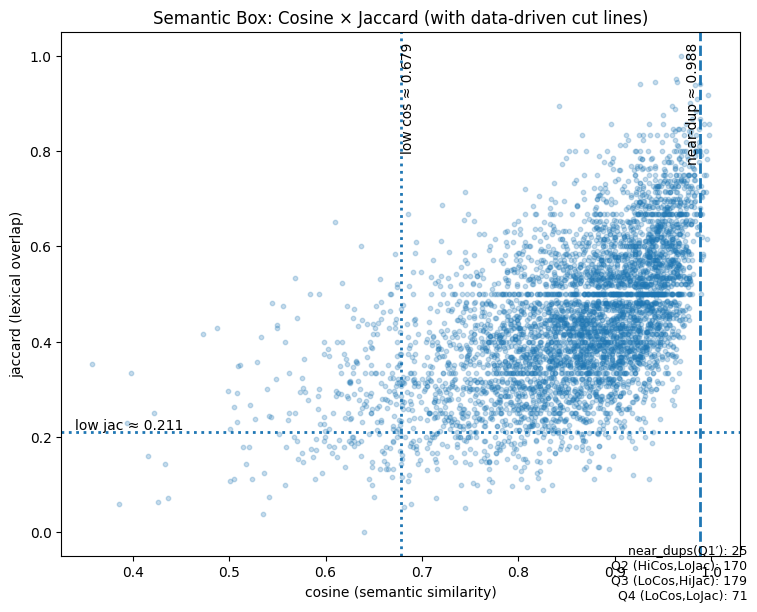

{'near_dups(Q1′)': 25,
 'Q2 (HiCos,LoJac)': 170,
 'Q3 (LoCos,HiJac)': 179,
 'Q4 (LoCos,LoJac)': 71}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sanity: require thresholds and columns
need_cols = ["cosine","jaccard"]
missing = [c for c in need_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns for Semantic Box: {missing}. Run previous EDA cells first.")

# Fallbacks if thresholds not defined (should be from Cell 31)
if "low_cos_thr" not in globals():  low_cos = float(np.percentile(df["cosine"].dropna(), 5))
else:                                low_cos = float(low_cos_thr)
if "low_jac_thr" not in globals():  low_jac = float(np.percentile(df["jaccard"].dropna(), 5))
else:                                low_jac = float(low_jac_thr)
if "near_dup_thr" not in globals(): near_dup = float(np.percentile(df["cosine"].dropna(), 99.5))
else:                                near_dup = float(near_dup_thr)

# Quadrant masks
Q1 = (df["cosine"] >= low_cos) & (df["jaccard"] >= low_jac) & (df["cosine"] >= near_dup)  # near-dups (subset)
Q2 = (df["cosine"] >= low_cos) & (df["jaccard"] <  low_jac)                               # high semantic, low lexical
Q3 = (df["cosine"] <  low_cos) & (df["jaccard"] >= low_jac)                               # low semantic, high lexical
Q4 = (df["cosine"] <  low_cos) & (df["jaccard"] <  low_jac)                               # low semantic, low lexical

counts = {
    "near_dups(Q1′)": int(Q1.sum()),
    "Q2 (HiCos,LoJac)": int(Q2.sum()),
    "Q3 (LoCos,HiJac)": int(Q3.sum()),
    "Q4 (LoCos,LoJac)": int(Q4.sum()),
}

plt.figure(figsize=(7.6, 6.2))
plt.scatter(df["cosine"], df["jaccard"], s=10, alpha=0.25)
plt.axvline(low_cos, linestyle=":", linewidth=2)
plt.axhline(low_jac, linestyle=":", linewidth=2)
plt.axvline(near_dup, linestyle="--", linewidth=2)

# Annotate quadrants
xmin, xmax = plt.xlim(); ymin, ymax = plt.ylim()
plt.text(near_dup, ymax*0.98, f'near-dup ≈ {near_dup:.3f}', rotation=90, va='top', ha='right')
plt.text(low_cos,  ymax*0.98, f'low cos ≈ {low_cos:.3f}', rotation=90, va='top', ha='left')
plt.text(xmin+(xmax-xmin)*0.02, low_jac, f'low jac ≈ {low_jac:.3f}', va='bottom', ha='left')

# Little legend box with counts
legend_txt = "\n".join([f"{k}: {v}" for k,v in counts.items()])
plt.gcf().text(0.99, 0.02, legend_txt, ha="right", va="bottom", fontsize=9)

plt.title("Semantic Box: Cosine × Jaccard (with data-driven cut lines)")
plt.xlabel("cosine (semantic similarity)")
plt.ylabel("jaccard (lexical overlap)")
plt.tight_layout()
plt.show()

counts

In [ ]:
# Set data-driven thresholds (same logic used in the auto-report)
import numpy as np

# Safety checks to ensure columns exist
req_cols = ['len_src_tokens','len_para_tokens','cosine','jaccard','edit_norm']
missing = [c for c in req_cols if c not in df.columns]
if missing:
    raise ValueError(f'Missing required columns: {missing}. Run earlier EDA cells first.')

# Length range (1st–99th percentile across both src/para token lengths)
len_min = int(np.percentile(df[['len_src_tokens','len_para_tokens']].min(axis=1), 1))
len_max = int(np.percentile(df[['len_src_tokens','len_para_tokens']].max(axis=1), 99))

# Near-duplicate cutoff (very high cosine)
near_dup_thr = float(np.percentile(df['cosine'].dropna(), 99.5))

# Low-similarity inspection band (potential drift/noise)
low_cos_thr = float(np.percentile(df['cosine'].dropna(), 5))
low_jac_thr = float(np.percentile(df['jaccard'].dropna(), 5))

# Heavy rewrite cutoff (high normalized edit distance)
high_edit_thr = float(np.percentile(df['edit_norm'].dropna(), 95))

len_min, len_max, near_dup_thr, low_cos_thr, low_jac_thr, high_edit_thr

(8,
 296,
 0.9880754962563515,
 0.6787121593952179,
 0.21052631578947367,
 0.7670493462017435)

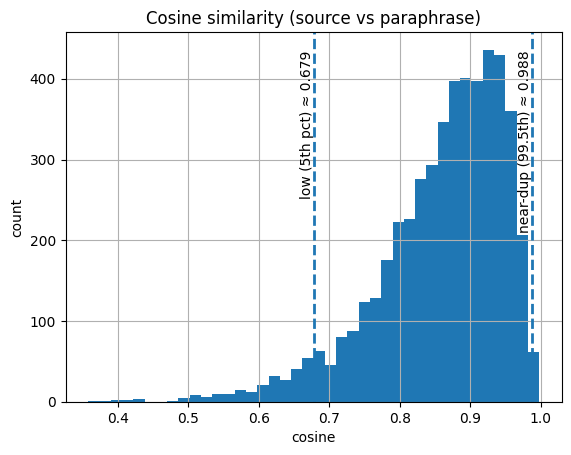

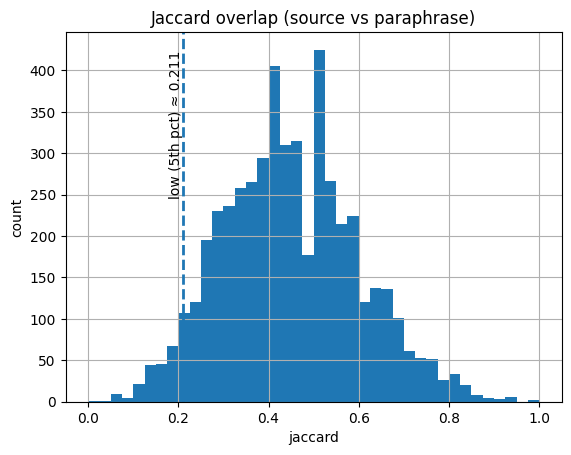

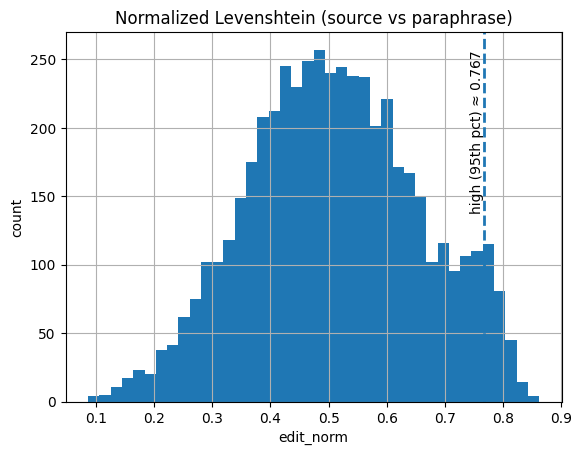

In [ ]:
import matplotlib.pyplot as plt

def plot_hist_with_lines(series, title, xlabel, vlines):
    plt.figure()
    series.hist(bins=40)
    for val, label in vlines:
        plt.axvline(val, linestyle='--', linewidth=2)
        plt.text(val, plt.ylim()[1]*0.95, label, rotation=90, va='top', ha='right')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('count')
    plt.show()

# Cosine
plot_hist_with_lines(
    df['cosine'],
    'Cosine similarity (source vs paraphrase)',
    'cosine',
    [(low_cos_thr, f'low (5th pct) ≈ {low_cos_thr:.3f}'), (near_dup_thr, f'near-dup (99.5th) ≈ {near_dup_thr:.3f}')]
)

# Jaccard
plot_hist_with_lines(
    df['jaccard'],
    'Jaccard overlap (source vs paraphrase)',
    'jaccard',
    [(low_jac_thr, f'low (5th pct) ≈ {low_jac_thr:.3f}')]
)

# Edit distance (normalized)
plot_hist_with_lines(
    df['edit_norm'],
    'Normalized Levenshtein (source vs paraphrase)',
    'edit_norm',
    [(high_edit_thr, f'high (95th pct) ≈ {high_edit_thr:.3f}')]
)

In [ ]:
from pathlib import Path

OUTPUT_DIR = Path('./artifacts')
OUTPUT_DIR.mkdir(exist_ok=True)

# Build boolean masks for each rule
mask_len = (df['len_src_tokens'].between(len_min, len_max)) & (df['len_para_tokens'].between(len_min, len_max))
mask_nd = df['cosine'] < near_dup_thr
mask_noise = ~((df['cosine'] <= low_cos_thr) & (df['jaccard'] <= low_jac_thr))
# (Optional) heavy rewrite diagnostic — not dropping by default; toggle if desired
mask_edit_diag = df['edit_norm'] < high_edit_thr

# Combine (current default: length + near-dup + noise)
mask_final = mask_len & mask_nd & mask_noise

clean_df = df.loc[mask_final].copy()

# Save cleaned pairs (retain key columns + metrics for SDS)
keep_cols = [c for c in ['idx','dataset_source','human_original_text(type1)','llm_paraphrased_original_text(type4)-prompt-based',
                         'len_src_tokens','len_para_tokens','len_delta_tokens','jaccard','edit_norm','cosine'] if c in df.columns]

out_path = OUTPUT_DIR / 'data_cleaned.csv'
clean_df[keep_cols].to_csv(out_path, index=False)

summary = {
    'total_rows': int(len(df)),
    'kept_rows': int(len(clean_df)),
    'kept_pct': round(100*len(clean_df)/len(df), 2),
    'dropped_len': int((~mask_len).sum()),
    'dropped_near_dups': int((~mask_nd).sum()),
    'dropped_noise': int((~mask_noise).sum()),
}
summary, out_path

({'total_rows': 5000,
  'kept_rows': 4817,
  'kept_pct': 96.34,
  'dropped_len': 93,
  'dropped_near_dups': 25,
  'dropped_noise': 71},
 PosixPath('artifacts/data_cleaned.csv'))

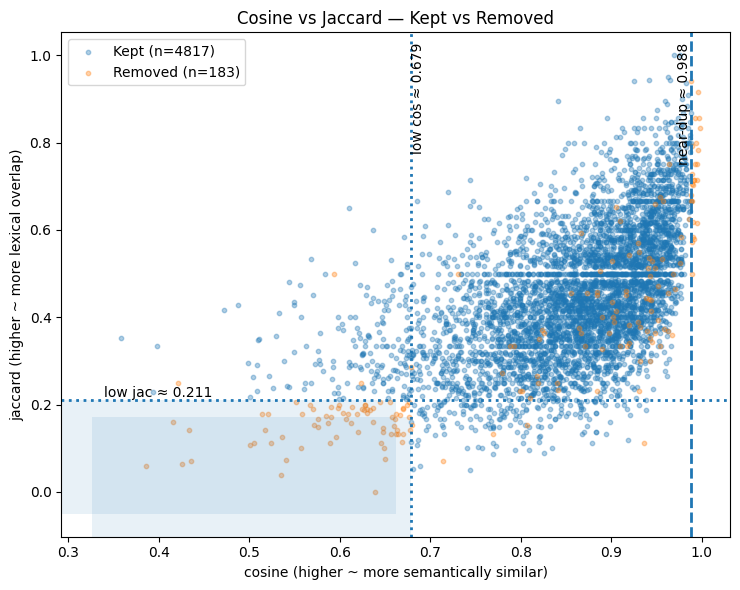

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Rebuild masks (in case you ran this cell standalone)
mask_len = (df['len_src_tokens'].between(len_min, len_max)) & (df['len_para_tokens'].between(len_min, len_max))
mask_nd = df['cosine'] < near_dup_thr
mask_noise = ~((df['cosine'] <= low_cos_thr) & (df['jaccard'] <= low_jac_thr))
mask_final = mask_len & mask_nd & mask_noise

kept = df[mask_final]
removed = df[~mask_final]

plt.figure(figsize=(7.5, 6))
plt.scatter(kept['cosine'], kept['jaccard'], s=10, alpha=0.35, label=f'Kept (n={len(kept)})')
plt.scatter(removed['cosine'], removed['jaccard'], s=10, alpha=0.35, label=f'Removed (n={len(removed)})')

# Shade the "drop zone" for low cosine & low Jaccard
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
plt.axvspan(xmin, low_cos_thr, ymin=0, ymax= (low_jac_thr - ymin) / (ymax - ymin), alpha=0.10)
plt.axhspan(ymin, low_jac_thr, xmin=0, xmax= (low_cos_thr - xmin) / (xmax - xmin), alpha=0.10)

# Near-duplicate vertical line
plt.axvline(near_dup_thr, linestyle='--', linewidth=2)
plt.text(near_dup_thr, ymax*0.98, f'near-dup ≈ {near_dup_thr:.3f}', rotation=90, va='top', ha='right')

# Low-similarity guide lines
plt.axvline(low_cos_thr, linestyle=':', linewidth=2)
plt.axhline(low_jac_thr, linestyle=':', linewidth=2)
plt.text(low_cos_thr, ymax*0.98, f'low cos ≈ {low_cos_thr:.3f}', rotation=90, va='top', ha='left')
plt.text(xmin + (xmax-xmin)*0.02, low_jac_thr, f'low jac ≈ {low_jac_thr:.3f}', va='bottom', ha='left')

plt.title('Cosine vs Jaccard — Kept vs Removed')
plt.xlabel('cosine (higher ~ more semantically similar)')
plt.ylabel('jaccard (higher ~ more lexical overlap)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# POS/NER drift analysis (optional; requires spaCy and a downloaded model)
# To install if needed:
# %pip install -q spacy
# python -m spacy download en_core_web_sm

import numpy as np

SPACY_OK = True
try:
    import spacy
    try:
        nlp = spacy.load("en_core_web_sm", disable=["lemmatizer"])
    except OSError:
        # Attempt to download model if not present (comment out if offline)
        # !python -m spacy download en_core_web_sm
        try:
            nlp = spacy.load("en_core_web_sm", disable=["lemmatizer"])
        except Exception:
            SPACY_OK = False
except Exception:
    SPACY_OK = False

def _safe_prob_vec(counts, vocab):
    """Turn counts dict into probability vector aligned to vocab order, with smoothing."""
    vec = np.array([counts.get(tag, 0) for tag in vocab], dtype=float)
    smoothed = (vec + 1.0) / (vec.sum() + len(vocab))
    return smoothed

def jensen_shannon_divergence(p, q):
    """JSD between two probability vectors."""
    p = np.asarray(p, dtype=float); q = np.asarray(q, dtype=float)
    p = p / p.sum(); q = q / q.sum()
    m = 0.5 * (p + q)
    def _kl(a, b):
        mask = (a > 0)
        return np.sum(a[mask] * np.log(a[mask] / b[mask]))
    return 0.5 * (_kl(p, m) + _kl(q, m))



In [ ]:
def pos_jsd_for_pair(doc_src, doc_para):
    """Compute JSD between POS distributions (UPOS-like tags)."""
    pos_src = {}
    pos_para = {}
    for tok in doc_src:
        if not tok.is_space:
            pos_src[tok.pos_] = pos_src.get(tok.pos_, 0) + 1
    for tok in doc_para:
        if not tok.is_space:
            pos_para[tok.pos_] = pos_para.get(tok.pos_, 0) + 1
    vocab = sorted(set(list(pos_src.keys()) + list(pos_para.keys())))
    p = _safe_prob_vec(pos_src, vocab)
    q = _safe_prob_vec(pos_para, vocab)
    return float(jensen_shannon_divergence(p, q))

def ner_prec_rec_for_pair(doc_src, doc_para):
    """Compute NER precision/recall comparing source vs paraphrase named entities (label-agnostic surface spans)."""
    ents_src = {(ent.text.strip().lower()) for ent in doc_src.ents if ent.text.strip()}
    ents_para = {(ent.text.strip().lower()) for ent in doc_para.ents if ent.text.strip()}
    if len(ents_src) == 0 and len(ents_para) == 0:
        return 1.0, 1.0  # nothing to match — treat as perfect
    # Precision: how many entities in paraphrase are also in the source?
    tp = len(ents_para & ents_src)
    prec = tp / max(1, len(ents_para))
    # Recall: how many entities from source are preserved in paraphrase?
    rec = tp / max(1, len(ents_src))
    return float(prec), float(rec)

SPACY_OK

True

In [ ]:
from tqdm import tqdm

if not SPACY_OK:
    print("spaCy or model not available; skipping POS/NER drift computation. Install spaCy and `en_core_web_sm` to enable.")
else:
    pos_jsd_vals = []
    ner_prec_vals = []
    ner_rec_vals = []

    # Efficient batch processing
    texts_src = df['human_original_text(type1)'].fillna('').tolist()
    texts_para = df['llm_paraphrased_original_text(type4)-prompt-based'].fillna('').tolist()

    # Process in pairs using two pipes to preserve order
    docs_src = list(nlp.pipe(texts_src, batch_size=64, n_process=1, disable=[]))
    docs_para = list(nlp.pipe(texts_para, batch_size=64, n_process=1, disable=[]))

    for d_s, d_p in tqdm(zip(docs_src, docs_para), total=len(docs_src)):
        # POS divergence
        pos_jsd_vals.append(pos_jsd_for_pair(d_s, d_p))
        # NER drift
        prec, rec = ner_prec_rec_for_pair(d_s, d_p)
        ner_prec_vals.append(prec)
        ner_rec_vals.append(rec)

    df['pos_jsd'] = pos_jsd_vals
    df['ner_prec'] = ner_prec_vals
    df['ner_rec'] = ner_rec_vals

    # Summaries
    print("POS JSD describe():")
    print(df['pos_jsd'].describe())

    print("\nNER precision/recall describe():")
    print(df[['ner_prec','ner_rec']].describe())

100%|██████████| 5000/5000 [00:00<00:00, 7059.04it/s]

POS JSD describe():
count    5000.000000
mean        0.014715
std         0.009760
min         0.000000
25%         0.007890
50%         0.012754
75%         0.019302
max         0.138506
Name: pos_jsd, dtype: float64

NER precision/recall describe():
          ner_prec      ner_rec
count  5000.000000  5000.000000
mean      0.755859     0.744003
std       0.315672     0.317529
min       0.000000     0.000000
25%       0.571429     0.500000
50%       1.000000     0.875000
75%       1.000000     1.000000
max       1.000000     1.000000


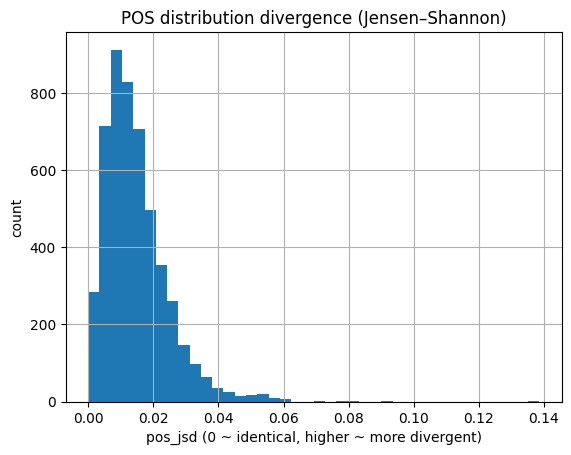

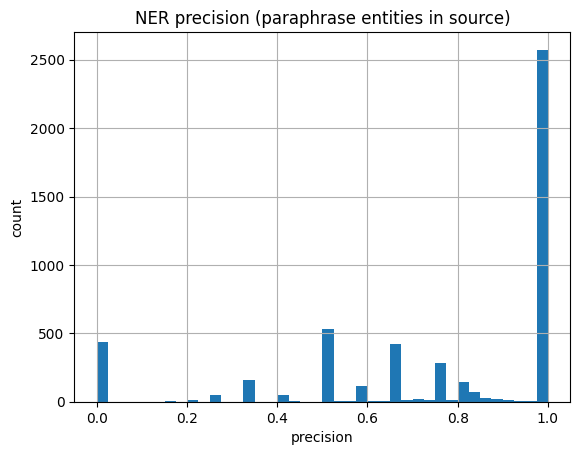

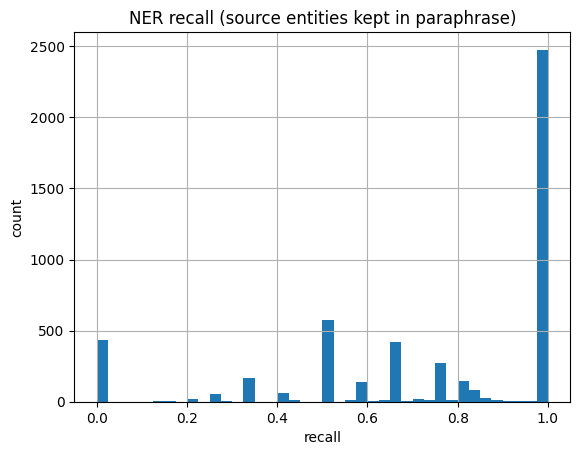


Means by dataset_source (POS/NER):
                pos_jsd  ner_prec  ner_rec
dataset_source                            
hlpc              0.015     0.730    0.725
mrpc              0.015     0.754    0.741
paws              0.015     0.777    0.766
Wrote: artifacts/pairs_with_metrics_plus_ling.csv


In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path

if 'pos_jsd' not in df.columns:
    print("POS/NER columns not found. Run the previous cell with spaCy enabled.")
else:
    # Histograms
    plt.figure()
    df['pos_jsd'].hist(bins=40)
    plt.title('POS distribution divergence (Jensen–Shannon)')
    plt.xlabel('pos_jsd (0 ~ identical, higher ~ more divergent)')
    plt.ylabel('count')
    plt.show()

    plt.figure()
    df['ner_prec'].hist(bins=40)
    plt.title('NER precision (paraphrase entities in source)')
    plt.xlabel('precision')
    plt.ylabel('count')
    plt.show()

    plt.figure()
    df['ner_rec'].hist(bins=40)
    plt.title('NER recall (source entities kept in paraphrase)')
    plt.xlabel('recall')
    plt.ylabel('count')
    plt.show()

    # Aggregates by dataset_source
    if 'dataset_source' in df.columns:
        agg = df.groupby('dataset_source')[['pos_jsd','ner_prec','ner_rec']].mean().round(3)
        print("\nMeans by dataset_source (POS/NER):")
        print(agg)

    # Export enhanced metrics for SDS pipeline
    OUTPUT_DIR = Path('./artifacts')
    OUTPUT_DIR.mkdir(exist_ok=True)
    extra_cols = [
        'idx','dataset_source',
        'len_src_tokens','len_para_tokens','len_delta_tokens',
        'jaccard','edit_norm','cosine',
        'pos_jsd','ner_prec','ner_rec'
    ]
    extra_cols = [c for c in extra_cols if c in df.columns]
    out_path = OUTPUT_DIR / 'pairs_with_metrics_plus_ling.csv'
    df[extra_cols].to_csv(out_path, index=False)
    print("Wrote:", out_path)

Entity Guardrail — Overall:
{'entity_drop_rate': 0.505, 'entity_add_rate': 0.485}

Entity Guardrail by dataset_source:
                entity_drop_flag  entity_add_flag
dataset_source                                   
hlpc                       0.603            0.597
mrpc                       0.492            0.470
paws                       0.517            0.501


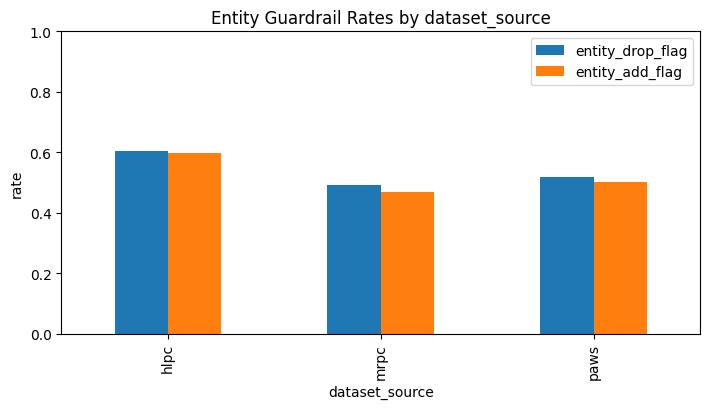

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Ensure ner columns exist (from earlier POS/NER cells)
need = ["ner_prec","ner_rec"]
missing = [c for c in need if c not in df.columns]
if missing:
    print(f"NER columns missing ({missing}). Run POS/NER drift cells first (Cells 35–37).")

# Flags (conservative: only flag when there were entities to evaluate)
eps = 1e-8
has_src_ents  = df["ner_rec"].notna()  # implies we tried NER
has_para_ents = df["ner_prec"].notna()

entity_drop_flag = (df["ner_rec"] < (1.0 - eps)) & has_src_ents
entity_add_flag  = (df["ner_prec"] < (1.0 - eps)) & has_para_ents

df["entity_drop_flag"] = entity_drop_flag.astype(int)
df["entity_add_flag"]  = entity_add_flag.astype(int)

# Overall rates
overall = {
    "entity_drop_rate": float(df["entity_drop_flag"].mean()),
    "entity_add_rate":  float(df["entity_add_flag"].mean()),
}

print("Entity Guardrail — Overall:")
print({k: round(v, 3) for k,v in overall.items()})

# By dataset_source
if "dataset_source" in df.columns:
    by_src = df.groupby("dataset_source")[["entity_drop_flag","entity_add_flag"]].mean().round(3)
    print("\nEntity Guardrail by dataset_source:")
    print(by_src)

    # Quick bars
    by_src.plot(kind="bar", figsize=(7.2,4.2))
    plt.title("Entity Guardrail Rates by dataset_source")
    plt.ylabel("rate")
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

# Relation to SDS (if exists)
if "sds" in df.columns:
    corr_drop = np.corrcoef(df["sds"].fillna(0), df["entity_drop_flag"])[0,1]
    corr_add  = np.corrcoef(df["sds"].fillna(0), df["entity_add_flag"])[0,1]
    print("\nCorrelation with SDS:")
    print({"sds↔entity_drop_flag": round(float(corr_drop),3),
           "sds↔entity_add_flag":  round(float(corr_add),3)})

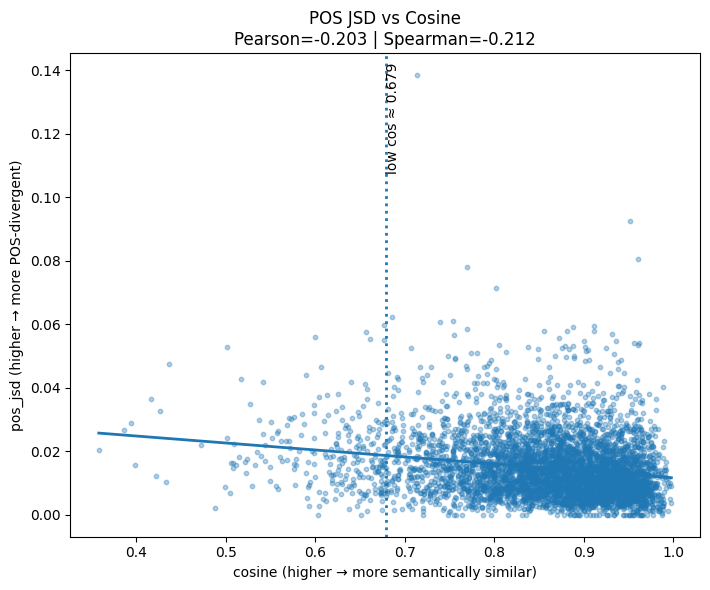

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sanity checks
need = ['pos_jsd', 'cosine']
missing = [c for c in need if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns for this plot: {missing}. Run the POS/NER drift cell and cosine cell first.")

# Drop rows with NaNs in either metric
sub = df[['pos_jsd', 'cosine']].dropna().copy()

# Correlations
pearson = np.corrcoef(sub['pos_jsd'], sub['cosine'])[0,1]
# Spearman (rank correlation)
from scipy.stats import spearmanr
spearman = spearmanr(sub['pos_jsd'], sub['cosine']).correlation

# Simple linear fit (y = a*x + b), here: pos_jsd ~ a*cosine + b
x = sub['cosine'].to_numpy()
y = sub['pos_jsd'].to_numpy()
a, b = np.polyfit(x, y, 1)
y_hat = a * x + b

plt.figure(figsize=(7.2, 6))
plt.scatter(x, y, s=10, alpha=0.35)
# Overlay best-fit line (sorted for monotonic rendering)
order = np.argsort(x)
plt.plot(x[order], y_hat[order], linewidth=2)

# Optional: vertical guide for low similarity region (use low_cos_thr if previously computed)
if 'low_cos_thr' in globals():
    plt.axvline(low_cos_thr, linestyle=':', linewidth=2)
    plt.text(low_cos_thr, plt.ylim()[1]*0.98, f'low cos ≈ {low_cos_thr:.3f}', rotation=90, va='top', ha='left')

plt.title(f'POS JSD vs Cosine\nPearson={pearson:.3f} | Spearman={spearman:.3f}')
plt.xlabel('cosine (higher → more semantically similar)')
plt.ylabel('pos_jsd (higher → more POS-divergent)')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

MODEL_COLS = [c for c in ["model_name","generator","llm_name","paraphrase_model"] if c in df.columns]
if MODEL_COLS:
    mcol = MODEL_COLS[0]
    print(f"Using logged model column: {mcol}")

    metrics = ["cosine","jaccard","edit_norm"]
    if "sds" in df.columns:
        metrics.append("sds")

    agg = df.groupby(mcol)[metrics].agg(["mean","std","count"]).round(3)
    display(agg)

    # Drift rate at thresholds (if SDS exists)
    if "sds" in df.columns:
        tau_bal = float(np.nanpercentile(df["sds"], 75))
        tau_hp  = float(np.nanpercentile(df["sds"], 90))
        dr_bal = df.assign(flag=(df["sds"]>=tau_bal).astype(int)).groupby(mcol)["flag"].mean().round(3)
        dr_hp  = df.assign(flag=(df["sds"]>=tau_hp ).astype(int)).groupby(mcol)["flag"].mean().round(3)
        print("\nDrift rate by model (balanced / high-precision):")
        print(pd.concat({"balanced": dr_bal, "high_precision": dr_hp}, axis=1))
else:
    print("No model column found (e.g., 'model_name' or 'generator'). You can enable on-the-fly T5 probing in the next cell.")

No model column found (e.g., 'model_name' or 'generator'). You can enable on-the-fly T5 probing in the next cell.


In [ ]:
# --- Robust T5 probing: CPU-only, no accelerate/device_map, with clear diagnostics ---
DO_T5_GENERATION = True   # set True to actually probe
MAX_INPUTS = 80            # keep small
VARIANTS_PER_INPUT = 3
SEEDS = [11, 17, 29][:VARIANTS_PER_INPUT]
SRC_COL = "human_original_text(type1)"

import sys, importlib, platform, re, numpy as np, pandas as pd

def _diag():
    print("=== ENV DIAGNOSTICS ===")
    print("Python:", sys.version)
    print("Executable:", sys.executable)
    try:
        import torch, transformers, sentencepiece
        print("torch:", torch.__version__, "| cuda_available:", torch.cuda.is_available())
        print("transformers:", transformers.__version__)
        print("sentencepiece:", sentencepiece.__version__)
    except Exception as e:
        print("Import check:", e)
    print("========================")

def _tok(x):
    return re.findall(r"\w+", str(x).lower())

def _jacc(a,b):
    A,B=set(_tok(a)), set(_tok(b))
    if not A and not B: return 1.0
    return len(A&B)/max(1, len(A|B))

def _edit_norm(a,b):
    try:
        from rapidfuzz.distance import Levenshtein as RFLev
        a,b=str(a),str(b)
        if not a and not b: return 0.0
        return RFLev.distance(a,b)/max(1, max(len(a),len(b)))
    except Exception:
        return np.nan

def _cosine_from_embeddings(src_list, para_list):
    # SBERT if available, else TF-IDF
    try:
        from sentence_transformers import SentenceTransformer
        st = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
        ems = st.encode(src_list + para_list, normalize_embeddings=True, show_progress_bar=False)
        n = len(src_list)
        srcE, parE = ems[:n], ems[n:]
        out = []
        for u,v in zip(srcE, parE):
            u = np.asarray(u); v = np.asarray(v)
            d = np.linalg.norm(u)*np.linalg.norm(v)
            out.append(float(np.dot(u,v)/d) if d>0 else 0.0)
        return out
    except Exception:
        from sklearn.feature_extraction.text import TfidfVectorizer
        from sklearn.metrics.pairwise import cosine_similarity
        X = TfidfVectorizer(min_df=2, max_df=0.9).fit_transform(src_list + para_list)
        n = len(src_list)
        sims = cosine_similarity(X[:n], X[n:])
        return [sims[i,i] for i in range(n)]

def _load_t5_any():
    """
    CPU-only loader. Tries t5-small, then flan-t5-small.
    Returns (tokenizer, model, model_name) or (None, None, None) if failed.
    """
    try:
        import torch
        from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
    except Exception as e:
        print("Transformers/Torch import failed:", e)
        return None, None, None

    candidates = ["t5-small", "google/flan-t5-small"]
    for name in candidates:
        try:
            print(f"Trying to load: {name} (CPU)")
            tok = AutoTokenizer.from_pretrained(name)
            mdl = AutoModelForSeq2SeqLM.from_pretrained(name)  # CPU; no device_map
            mdl.to("cpu")
            # Smoke test
            test = tok.encode("paraphrase: hello world", return_tensors="pt", truncation=True, max_length=48)
            with torch.no_grad():
                out = mdl.generate(test, max_length=48)
            _ = tok.decode(out[0], skip_special_tokens=True)
            print(f"Loaded OK: {name}")
            return tok, mdl, name
        except Exception as e:
            print(f"Failed: {name} → {repr(e)}")
            continue
    return None, None, None

def _generate_paraphrases(tok, mdl, text, seed=0):
    import torch, random
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    inp = "paraphrase: " + text
    ids = tok.encode(inp, return_tensors="pt", truncation=True, max_length=128)
    with torch.no_grad():
        out = mdl.generate(
            ids,
            max_length=128,
            do_sample=True,
            top_p=0.92,
            top_k=50,
            num_beams=1,
            num_return_sequences=1,
        )
    return tok.decode(out[0], skip_special_tokens=True)

# --- Run ---
_diag()

if not DO_T5_GENERATION:
    print("T5 generation disabled. Set DO_T5_GENERATION=True to probe on a small sample.")
else:
    # Preconditions
    if SRC_COL not in df.columns:
        raise ValueError(f"Missing source column: {SRC_COL}")

    # Try to import sentencepiece early for clearer errors
    try:
        import sentencepiece  # noqa: F401
    except Exception as e:
        raise RuntimeError(
            "sentencepiece missing in THIS kernel. Run:\n"
            "%pip install -q sentencepiece transformers torch --upgrade\n"
            "Then restart kernel and re-run."
        )

    tok, mdl, model_name = _load_t5_any()
    if tok is None:
        print("Could not load any T5 model on CPU. "
              "Common fixes:\n"
              "  1) In a notebook cell: %pip install -q --upgrade transformers torch sentencepiece\n"
              "  2) Restart the kernel\n"
              "  3) (Corporate/Limited network?) Ensure model download isn’t blocked")
    else:
        print(f"Using model: {model_name}")
        sample = df.sample(min(MAX_INPUTS, len(df)), random_state=42)
        rows = []
        for i, s in enumerate(sample[SRC_COL].astype(str).tolist()):
            for j, seed in enumerate(SEEDS):
                try:
                    p = _generate_paraphrases(tok, mdl, s, seed=seed)
                except Exception as e:
                    p = ""
                rows.append({"group_id": i, "variant": j, "src": s, "para": p})

        gen = pd.DataFrame(rows)
        gen["jaccard"]   = [_jacc(a,b) for a,b in zip(gen["src"], gen["para"])]
        gen["edit_norm"] = [_edit_norm(a,b) for a,b in zip(gen["src"], gen["para"])]
        gen["cosine"]    = _cosine_from_embeddings(gen["src"].tolist(), gen["para"].tolist())

        stab = gen.groupby("group_id")[["cosine","jaccard","edit_norm"]].agg(["mean","std"]).round(3)
        print("T5 paraphrase stability (per source; mean/std over variants):")
        display(stab.head(10))

        print("\nAggregate stability (std across variants; lower = more stable):")
        print(stab.xs("std", axis=1, level=1).mean().round(3).to_dict())


=== ENV DIAGNOSTICS ===
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Executable: /usr/bin/python3
torch: 2.8.0+cu126 | cuda_available: False
transformers: 4.57.1
sentencepiece: 0.2.1
Trying to load: t5-small (CPU)


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Loaded OK: t5-small
Using model: t5-small
T5 paraphrase stability (per source; mean/std over variants):


cosine        jaccard        edit_norm    
           mean    std    mean    std      mean std
group_id                                           
0         0.061  0.042   0.000  0.000       NaN NaN
1        -0.053  0.014   0.000  0.000       NaN NaN
2         0.067  0.003   0.000  0.000       NaN NaN
3         0.150  0.000   0.000  0.000       NaN NaN
4         0.047  0.059   0.000  0.000       NaN NaN
5         0.143  0.000   0.000  0.000       NaN NaN
6         0.127  0.032   0.000  0.000       NaN NaN
7         0.724  0.406   0.683  0.492       NaN NaN
8         0.570  0.440   0.549  0.491       NaN NaN
9         0.029  0.053   0.000  0.000       NaN NaN


Aggregate stability (std across variants; lower = more stable):
{'cosine': 0.12, 'jaccard': 0.096, 'edit_norm': nan}


In [ ]:
metrics_cols = [
    'idx','dataset_source',
    'len_src_tokens','len_para_tokens','len_delta_tokens',
    'jaccard','edit_norm','cosine'
]
for c in metrics_cols:
    if c not in df.columns:
        df[c] = df.get(c, np.nan)

out_path = OUTPUT_DIR / 'pairs_with_metrics.csv'
df[metrics_cols].to_csv(out_path, index=False)
print('Wrote:', out_path)

Wrote: artifacts/pairs_with_metrics.csv


In [ ]:
df.head()

,idx,dataset_source,human_original_text(type1),llm_generated_text(type2),human_paraphrased_text(type3),llm_paraphrased_original_text(type4)-prompt-based,llm_paraphrased_generated_text(type5)-1st,llm_paraphrased_generated_text(type5)-3rd,len_src_chars,len_src_tokens,...,len_delta_chars,len_delta_tokens,jaccard,edit_norm,cosine,pos_jsd,ner_prec,ner_rec,entity_drop_flag,entity_add_flag
0,0,mrpc,"Amrozi accused his brother , whom he called "" ...",Amrozi accused his brother of being an accompl...,"Referring to him as only "" the witness "" , Amr...","Amrozi charged his brother, ""the witness,"" wit...",Amrozi claimed his brother participated in the...,Amrozi claimed his brother participated in the...,103,14,...,-17,-3,0.277778,0.504854,0.880767,0.004655,1.000000,1.000000,0,0
1,1,mrpc,They had published an advertisement on the Int...,They had published an advertisement on the int...,"On June 10 , the ship 's owners had published ...",He noted they had advertised the cargo for sal...,They had publicized the upcoming June cargo sa...,The company publicized its planned June shippi...,105,18,...,-22,-2,0.391304,0.657143,0.894484,0.009870,1.000000,1.000000,0,0
2,2,mrpc,"The stock rose $ 2.11 , or about 11 percent , ...","The stock rose $ 2.50, or 3 percent, on Friday...",PG & E Corp. shares jumped $ 1.63 or 8 percent...,"Shares gained $2.11 (about 11%), concluding Fr...","On Friday, the stock's value increased by $2.5...","On Friday, the stock's price rose $2.50 (3%), ...",105,21,...,-22,-5,0.375000,0.619048,0.692475,0.012596,0.600000,0.600000,1,1
3,3,mrpc,Revenue in the first quarter of the year dropp...,Revenue in the third quarter increased by 15 p...,With the scandal hanging over Stewart 's compa...,Q1 sales decreased 15 percent compared to the ...,Our third-quarter revenue grew 15% over the sa...,We experienced a 15% revenue surge in Q3 compa...,97,18,...,-20,-5,0.217391,0.690722,0.669427,0.029367,0.333333,0.333333,1,1
4,4,mrpc,The DVD-CCA then appealed to the state Supreme...,The DVD was submitted as evidence to the state...,The DVD CCA appealed that decision to the U.S....,The DVD-CCA subsequently appealed to the state...,The state supreme court received the DVD as ev...,The state's highest court accepted the DVD as ...,54,10,...,7,0,0.800000,0.180328,0.960815,0.000000,0.500000,1.000000,0,1


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np

OUTPUT_DIR = Path('./artifacts')
OUTPUT_DIR.mkdir(exist_ok=True)

lines = []
lines.append('# EDA Summary Report\n')

n_rows = len(df)
cols = list(df.columns)
nulls = df.isna().sum().sort_values(ascending=False)

lines.append(f'- **Total pairs:** {n_rows}')
if 'dataset_source' in df.columns:
    src_counts = df['dataset_source'].value_counts(dropna=False).to_dict()
    lines.append(f'- **By dataset_source:** {src_counts}')
lines.append(f'- **Columns:** {cols}')

lines.append('\n## Null Overview (Top 10)\n')
lines.append(nulls.head(10).to_markdown())

len_cols = [c for c in ['len_src_tokens','len_para_tokens','len_delta_tokens'] if c in df.columns]
if len_cols:
    len_stats = df[len_cols].describe().round(3)
    lines.append('\n## Length Statistics\n')
    lines.append(len_stats.to_markdown())

sim_cols = [c for c in ['jaccard','edit_norm','cosine'] if c in df.columns]
if sim_cols:
    sim_stats = df[sim_cols].describe().round(3)
    lines.append('\n## Similarity Statistics\n')
    lines.append(sim_stats.to_markdown())

if 'dataset_source' in df.columns:
    agg_cols = [c for c in ['cosine','jaccard','edit_norm','len_src_tokens','len_para_tokens','len_delta_tokens'] if c in df.columns]
    if agg_cols:
        grp = df.groupby('dataset_source')[agg_cols].mean().round(3)
        lines.append('\n## Means by dataset_source\n')
        lines.append(grp.to_markdown())

nli_present = all(c in df.columns for c in ['nli_ent_src_para','nli_ent_para_src','nli_contra_max'])
if nli_present:
    nli_stats = df[['nli_ent_src_para','nli_ent_para_src','nli_contra_max']].describe().round(3)
    lines.append('\n## NLI Summary (if sampled earlier)\n')
    lines.append(nli_stats.to_markdown())

lines.append('\n## Suggested Cleaning Thresholds (Initial Heuristics)\n')
suggestions = []
if 'len_src_tokens' in df.columns and 'len_para_tokens' in df.columns:
    import numpy as _np
    q_lo = int(_np.percentile(df[['len_src_tokens','len_para_tokens']].min(axis=1), 1))
    q_hi = int(_np.percentile(df[['len_src_tokens','len_para_tokens']].max(axis=1), 99))
    suggestions.append(f'- Drop extreme lengths: keep token counts within [{q_lo}, {q_hi}] (1st–99th pct).')
if 'cosine' in df.columns and df['cosine'].notna().any():
    near_dup_thr = float(np.percentile(df['cosine'].dropna(), 99.5))
    suggestions.append(f'- Remove near-duplicates: cosine ≥ {near_dup_thr:.3f} (99.5th pct).')
if set(['cosine','jaccard']).issubset(df.columns):
    low_sim_cos = float(np.percentile(df['cosine'].dropna(), 5))
    low_sim_jac = float(np.percentile(df['jaccard'].dropna(), 5))
    suggestions.append(f'- Inspect likely drift/noise: cosine ≤ {low_sim_cos:.3f} AND jaccard ≤ {low_sim_jac:.3f} (bottom 5th pct).')
if 'edit_norm' in df.columns and df['edit_norm'].notna().any():
    high_edit_thr = float(np.percentile(df['edit_norm'].dropna(), 95))
    suggestions.append(f'- Inspect heavy rewrites: edit_norm ≥ {high_edit_thr:.3f} (95th pct).')

if suggestions:
    lines.extend(suggestions)
else:
    lines.append('- (Run earlier cells to populate similarity/length metrics)')

report_path = OUTPUT_DIR / 'EDA_Report.md'
report_path.write_text('\n'.join(lines), encoding='utf-8')
print('Wrote EDA report to:', report_path)

from IPython.display import Markdown, display
display(Markdown('\n'.join(lines)))

Wrote EDA report to: artifacts/EDA_Report.md


# EDA Summary Report

- **Total pairs:** 5000
- **By dataset_source:** {'mrpc': 3750, 'paws': 870, 'hlpc': 380}
- **Columns:** ['idx', 'dataset_source', 'human_original_text(type1)', 'llm_generated_text(type2)', 'human_paraphrased_text(type3)', 'llm_paraphrased_original_text(type4)-prompt-based', 'llm_paraphrased_generated_text(type5)-1st', 'llm_paraphrased_generated_text(type5)-3rd', 'len_src_chars', 'len_src_tokens', 'len_para_chars', 'len_para_tokens', 'len_delta_chars', 'len_delta_tokens', 'jaccard', 'edit_norm', 'cosine', 'pos_jsd', 'ner_prec', 'ner_rec', 'entity_drop_flag', 'entity_add_flag']

## Null Overview (Top 10)

|                                                   |   0 |
|:--------------------------------------------------|----:|
| idx                                               |   0 |
| dataset_source                                    |   0 |
| human_original_text(type1)                        |   0 |
| llm_generated_text(type2)                         |   0 |
| human_paraphrased_text(type3)                     |   0 |
| llm_paraphrased_original_text(type4)-prompt-based |   0 |
| llm_paraphrased_generated_text(type5)-1st         |   0 |
| llm_paraphrased_generated_text(type5)-3rd         |   0 |
| len_src_chars                                     |   0 |
| len_src_tokens                                    |   0 |

## Length Statistics

|       |   len_src_tokens |   len_para_tokens |   len_delta_tokens |
|:------|-----------------:|------------------:|-------------------:|
| count |         5000     |          5000     |           5000     |
| mean  |           26.033 |            23.298 |             -2.736 |
| std   |           41.965 |            40.341 |              4.677 |
| min   |            4     |             4     |           -129     |
| 25%   |           16     |            14     |             -4     |
| 50%   |           20     |            17     |             -2     |
| 75%   |           24     |            21     |             -1     |
| max   |          444     |           453     |             38     |

## Similarity Statistics

|       |   jaccard |   edit_norm |   cosine |
|:------|----------:|------------:|---------:|
| count |  5000     |    5000     | 5000     |
| mean  |     0.448 |       0.51  |    0.859 |
| std   |     0.15  |       0.148 |    0.09  |
| min   |     0     |       0.087 |    0.358 |
| 25%   |     0.345 |       0.406 |    0.812 |
| 50%   |     0.44  |       0.506 |    0.878 |
| 75%   |     0.543 |       0.613 |    0.926 |
| max   |     1     |       0.862 |    0.998 |

## Means by dataset_source

| dataset_source   |   cosine |   jaccard |   edit_norm |   len_src_tokens |   len_para_tokens |   len_delta_tokens |
|:-----------------|---------:|----------:|------------:|-----------------:|------------------:|-------------------:|
| hlpc             |    0.869 |     0.412 |       0.505 |          100.3   |            95.132 |             -5.168 |
| mrpc             |    0.844 |     0.429 |       0.521 |           20.268 |            17.58  |             -2.688 |
| paws             |    0.919 |     0.545 |       0.468 |           18.444 |            16.566 |             -1.878 |

## Suggested Cleaning Thresholds (Initial Heuristics)

- Drop extreme lengths: keep token counts within [8, 296] (1st–99th pct).
- Remove near-duplicates: cosine ≥ 0.988 (99.5th pct).
- Inspect likely drift/noise: cosine ≤ 0.679 AND jaccard ≤ 0.211 (bottom 5th pct).
- Inspect heavy rewrites: edit_norm ≥ 0.767 (95th pct).

Adding more metrices

In [ ]:
# Install the 'sentence-transformers' library, used for generating sentence embeddings.
!pip install sentence-transformers
# Install the 'nltk' (Natural Language Toolkit) library, used for natural language processing tasks.
!pip install nltk
# Install the 'rouge-score' library, used for calculating ROUGE scores for text summarization and generation evaluation.
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=e23563b39199947c3ec926163fee11e446e1248a45fe20f591bb2aa3d86e1a38
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [ ]:
# Import the nltk library.
import nltk
# Download the 'wordnet' corpus from NLTK, which is a lexical database for the English language.
nltk.download('wordnet')
# Download the 'omw-1.4' (Open Multilingual Wordnet) corpus from NLTK.
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# Import SentenceTransformer from the sentence_transformers library.
from sentence_transformers import SentenceTransformer
# Import the numpy library for numerical operations, especially array manipulation.
import numpy as np

# Initialize a SentenceTransformer model using the 'all-mpnet-base-v2' pre-trained model.
# This model is suitable for generating high-quality sentence embeddings.
model = SentenceTransformer('all-mpnet-base-v2')

# Encode the source text column of the DataFrame into sentence embeddings.
# The embeddings are processed in batches of 32 for efficiency, and a progress bar is displayed.
# Using previously defined COL_SOURCE for consistency.
src_emb = model.encode(df[COL_SOURCE].tolist(), batch_size=32, show_progress_bar=True)
# Encode the paraphrased text column into sentence embeddings.
# Using previously defined COL_PARA for consistency.
para_emb = model.encode(df[COL_PARA].tolist(), batch_size=32, show_progress_bar=True)

# Calculate the Euclidean distance between the source and paraphrased text embeddings.
# This metric quantifies the semantic similarity, where a smaller distance indicates higher similarity.
df['sbert_euclid'] = np.linalg.norm(src_emb - para_emb, axis=1)

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
# Import the meteor_score function from nltk.translate.meteor_score.
from nltk.translate.meteor_score import meteor_score
# Import the re module for regular expressions.
import re

# Define a helper function to tokenize a string by converting it to lowercase and extracting alphanumeric words.
def simple_tokens(s):
    return re.findall(r"\w+", s.lower())

# Calculate the METEOR score for each pair of 'clean_source' and 'clean_para' texts.
# METEOR (Metric for Evaluation of Translation with Explicit Ordering) is a metric for evaluating machine translation quality.
# It calculates the score based on exact, stem, synonym, and paraphrase matches between the reference and hypothesis.
df['meteor'] = [
    meteor_score([simple_tokens(a)], simple_tokens(b))
    for a,b in zip(df[COL_SOURCE], df[COL_PARA])
]

In [ ]:
# Import rouge_scorer from the rouge_score library.
from rouge_score import rouge_scorer

# Initialize a ROUGE scorer. We are interested in 'rougeL' (ROUGE-L: Longest Common Subsequence based statistics).
# The use_stemmer=True argument enables Porter stemmer for more robust matching.
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

# Calculate the ROUGE-L F-measure score for each pair of 'clean_source' and 'clean_para' texts.
# ROUGE-L measures the overlap of the longest common subsequence between the generated text and the reference text.
df['rouge_l'] = [
    scorer.score(a, b)['rougeL'].fmeasure
    for a, b in zip(df[COL_SOURCE], df[COL_PARA])
]

In [ ]:
# Import MinMaxScaler from sklearn.preprocessing, used for scaling features to a specified range, typically 0 to 1.
from sklearn.preprocessing import MinMaxScaler

# Create inverted versions of the METEOR and ROUGE-L scores.
# This is done so that all metrics (Euclidean distance, inverted METEOR, inverted ROUGE-L) have the same interpretation:
# a higher value implies less similarity or greater difference, making them comparable after scaling.
df['meteor_inv'] = 1 - df['meteor']
df['rouge_l_inv'] = 1 - df['rouge_l']

# Initialize the MinMaxScaler.
scaler = MinMaxScaler()

# Apply Min-Max scaling to the 'sbert_euclid', 'meteor_inv', and 'rouge_l_inv' columns.
# This transforms the values of these columns so they all fall within a 0-1 range.
df[['sbert_euclid', 'meteor_inv', 'rouge_l_inv']] = scaler.fit_transform(
    df[['sbert_euclid', 'meteor_inv', 'rouge_l_inv']]
)

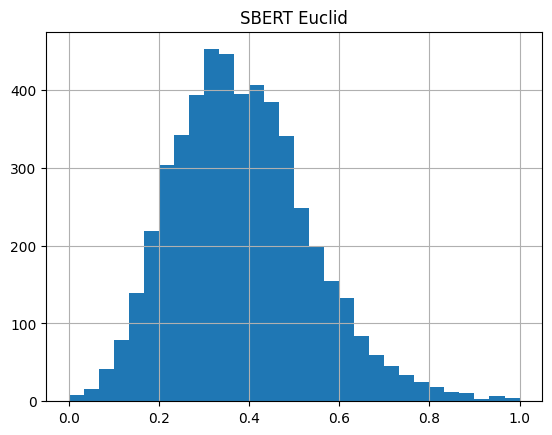

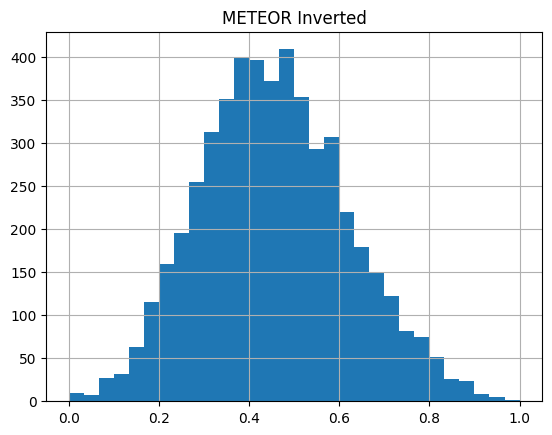

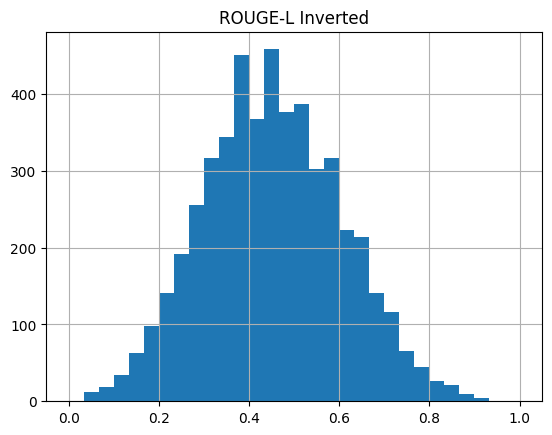

In [ ]:
# Display descriptive statistics (count, mean, std, min, 25%, 50%, 75%, max) for the scaled metric columns.
df[['sbert_euclid', 'meteor_inv', 'rouge_l_inv']].describe()
# Import the matplotlib.pyplot library for plotting, aliased as plt.
import matplotlib.pyplot as plt

# Generate a histogram for the 'sbert_euclid' column with 30 bins.
# Set the title of the histogram.
df['sbert_euclid'].hist(bins=30); plt.title("SBERT Euclid")
# Display the plot.
plt.show()

# Generate a histogram for the 'meteor_inv' column with 30 bins.
# Set the title of the histogram.
df['meteor_inv'].hist(bins=30); plt.title("METEOR Inverted")
# Display the plot.
plt.show()

# Generate a histogram for the 'rouge_l_inv' column with 30 bins.
# Set the title of the histogram.
df['rouge_l_inv'].hist(bins=30); plt.title("ROUGE-L Inverted")
# Display the plot.
plt.show()

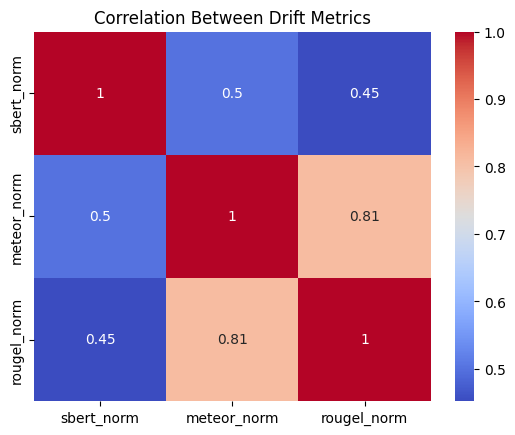

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply Min-Max scaling to selected columns and create new normalized columns
df[['sbert_norm','meteor_norm','rougel_norm']] = scaler.fit_transform(
    df[['sbert_euclid','meteor_inv','rouge_l_inv']]
)

# Create a heatmap to visualize the correlation between the normalized drift metrics
sns.heatmap(
    df[['sbert_norm','meteor_norm','rougel_norm']].corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title("Correlation Between Drift Metrics")
plt.show()

In [ ]:
# Calculate the Semantic Drift Score (SDS) using a weighted average of normalized metrics
df['SDS'] = (
    0.6 * df['sbert_norm'] +
    0.2 * df['meteor_norm'] +
    0.2 * df['rougel_norm']
)

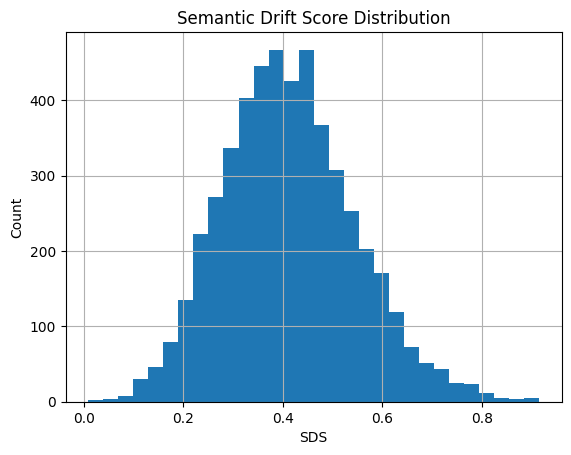

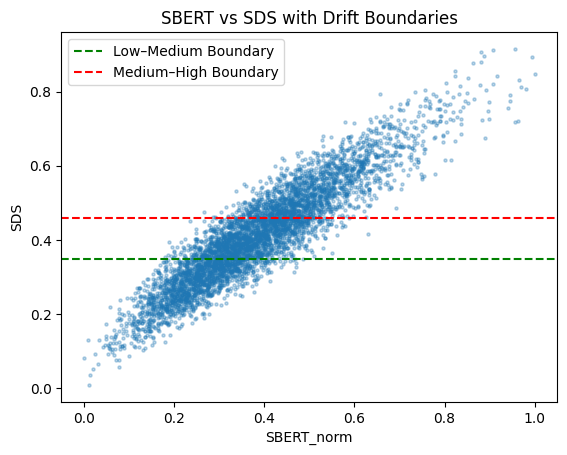

In [ ]:
import matplotlib.pyplot as plt

# Plot a histogram of the Semantic Drift Score (SDS) distribution
df['SDS'].hist(bins=30)
plt.title("Semantic Drift Score Distribution")
plt.xlabel("SDS")
plt.ylabel("Count")
plt.show()

# Create a scatter plot to visualize the relationship between SBERT_norm and SDS
plt.scatter(df['sbert_norm'], df['SDS'], s=5, alpha=0.3)

# drift category boundaries
l = df['SDS'].quantile(0.33)
m = df['SDS'].quantile(0.66)

plt.axhline(l, color='green', linestyle='--', label='Low–Medium Boundary')
plt.axhline(m, color='red', linestyle='--', label='Medium–High Boundary')

plt.xlabel("SBERT_norm")
plt.ylabel("SDS")
plt.title("SBERT vs SDS with Drift Boundaries")
plt.legend()
plt.show()

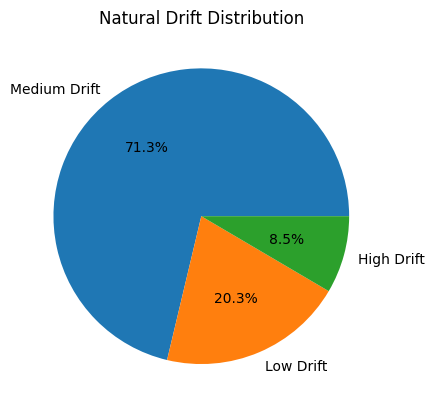

In [ ]:
df['drift_bin_real'] = pd.cut(
    df['SDS'],
    bins=[0, 0.3, 0.6, 1.0],
    labels=['Low Drift','Medium Drift','High Drift']
)

# Plot a pie chart to show the distribution of the natural drift categories
df['drift_bin_real'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Natural Drift Distribution")
plt.ylabel("")
plt.show()

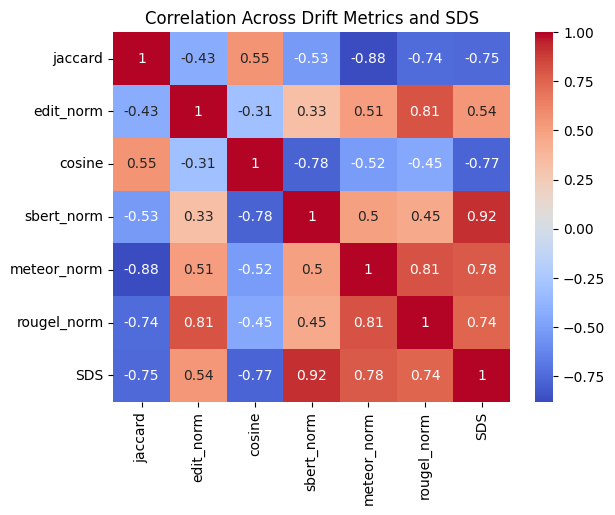

In [ ]:
import seaborn as sns

# Define the columns to include in the correlation matrix
corr_cols = ['jaccard','edit_norm','cosine','sbert_norm','meteor_norm','rougel_norm','SDS']
# Create a heatmap to visualize the correlation across drift metrics and SDS
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Across Drift Metrics and SDS")
plt.show()